In [2]:
# загружаем необходимые библиотеки
import warnings

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

warnings.filterwarnings("ignore")

# загружаем датафрейм
df = pd.read_csv("discountuplift.csv", sep="\t")

df["old_target"] = (df["target_class"] % 2).apply(int)

feature_cols = [
    "recency",
    "history",
    "used_discount",
    "used_bogo",
    "is_referral",
    "zip_code_Rural",
    "zip_code_Surburban",
    "zip_code_Urban",
    "channel_Multichannel",
    "channel_Phone",
    "channel_Web",
]
target_col = "old_target"
treatment_col = "treatment"

# разобъём нашу выборку на тестовую и валидационную
df_train, df_test = train_test_split(
    df, stratify=df[[treatment_col, target_col]], random_state=1, test_size=0.25
)


In [4]:
from causalml.inference.tree import UpliftTreeClassifier

# создадим uplift-дерево
uplift_model = UpliftTreeClassifier(
    max_depth=5,
    min_samples_leaf=200,
    min_samples_treatment=50,
    n_reg=100,
    evaluationFunction="ED",
    control_name="0",
)

uplift_model.fit(
    df_train[feature_cols].values,
    treatment=df_train[treatment_col].apply(str).values,
    y=df_train[target_col].values,
)

In [ ]:
# загружаем необходимые библиотеки
import pickle

with open("./models/model.pkl", "wb") as f:
    pickle.dump(uplift_model, f)

In [10]:
from matplotlib import pyplot as plt

def qini_df(df):
    # отранжируем выборку по значению uplift в порядке убывания
    ranked = df.sort_values("uplift_score", ascending=False)
    
    N_c = sum(ranked['target_class'] <= 1)
    N_t = sum(ranked['target_class'] >= 2)
    
    # посчитаем в отсортированном датафрейме основные показатели, 
    # которые используются при расчёте Qini Score
    ranked['n_c1'] = 0
    ranked['n_t1'] = 0
    ranked.loc[ranked.target_class == 1,'n_c1'] = 1
    ranked.loc[ranked.target_class == 3,'n_t1'] = 1
    ranked['n_c1/nc'] = ranked.n_c1.cumsum() / N_c
    ranked['n_t1/nt'] = ranked.n_t1.cumsum() / N_t
    
    # посчитаем Qini-кривую и случайную прямую под ней
    ranked['uplift'] = round(ranked['n_t1/nt'] - ranked['n_c1/nc'],5)
    # добавим случайную кривую
    ranked['random_uplift'] = round(ranked["uplift_score"].rank(pct=True, ascending=False) * ranked['uplift'].iloc[-1],5)
    
    ranked["n"] = ranked["uplift_score"].rank(pct=True, ascending=False)
    # немного кода для визуализации
    plt.plot(ranked['n'], ranked['uplift'], color='r')
    plt.plot(ranked['n'], ranked['random_uplift'], color='b')
    plt.show()
    
    return (ranked['uplift'] - ranked['random_uplift']).sum()

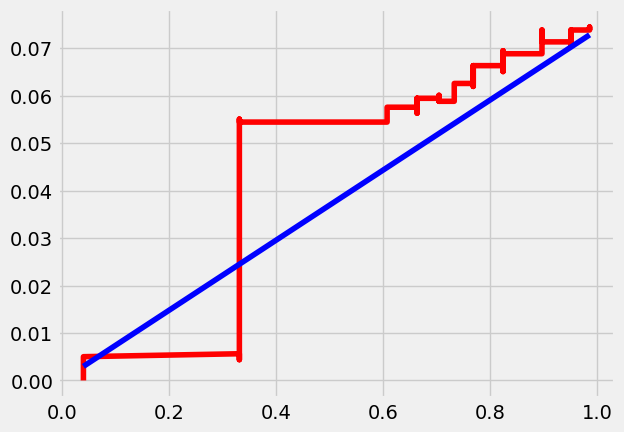

19.095919999999996

In [11]:
uplift_vals = uplift_model.predict(np.array(df_test[feature_cols].values.copy()))
df_test['uplift_score'] = uplift_vals

qini_df(df_test)
# посчитаем метрики 

In [13]:
uplift_model.classes_

['0', '1']